<a href="https://colab.research.google.com/github/vneumannufprbr/PracticasTensorflow/blob/main/Regresi%C3%B3n_con_Auto_MPGOkGit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paso 1: Cargar Datos

In [26]:
# -*- coding: utf-8 -*-
"""
Práctica de Regresión: Predicción de Consumo de Combustible de Vehiculos
(Millas Por Galón - MPG). Este script implementa un modelo de regresión con
TensorFlow y Keras para predecir la eficiencia de combustible de automóviles.
"""
# 1.1 Importación de Librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(f"TensorFlow version: {tf.__version__}")

# 1.2 Carga
# Descargar el dataset desde el repositorio de UCI
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
# Definir los nombres de las columnas según la documentación del dataset
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
# Cargar los datos usando pandas
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

TensorFlow version: 2.18.0


Paso 2: Preprocesar

In [27]:
# 2.1 Limpiar los datos eliminando filas con valores nulos
print(f"Número de filas con valores nulos: {dataset.isnull().sum().sum()}")
dataset = dataset.dropna()
print(f"Dataset limpio. Número de filas: {len(dataset)}")

# 2.2 Pre-procesamiento de Características Categóricas
# La columna 'Origin' es categórica, no numérica. La convertiremos a one-hot encoding.
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
# 2.3. División de Datos en Entrenamiento y Prueba
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
# 2.4 Separación de Características y Etiquetas
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# 2.5. Normalización de Datos
# Es crucial normalizar las características que tienen diferentes #escalas y rangos.
# Se utiliza la media y la desviación estándar del conjunto de entrenamiento para normalizar ambos conjuntos.
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Número de filas con valores nulos: 6
Dataset limpio. Número de filas: 392


Pasos 3 y 4: Construcción y Compilación del Modelo de Regresión

In [28]:
# 3. Construcción del Modelo de Regresión
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # Capa de salida: 1 neurona, sin activación
  ])

  # Usamos el optimizador RMSprop, común para regresión
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # 4. Compilamos el modelo con pérdida 'mse' y métricas 'mae' y 'mse'
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

Paso 5. Entrenamiento del Modelo con EarlyStopping

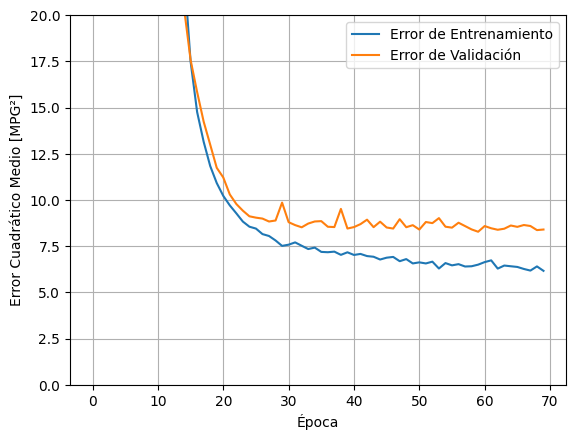

In [29]:
# 5.1 Entrenamiento del Modelo con EarlyStopping
# El callback EarlyStopping detiene el entrenamiento si no hay mejora para evitar el sobreajuste.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[early_stop])

# 5.2 Visualización de la Evolución de la Pérdida
# Graficar la función de pérdida (loss) a lo largo de las épocas para entrenamiento y validación.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.figure()
plt.xlabel('Época')
plt.ylabel('Error Cuadrático Medio [MPG²]')
plt.plot(hist['epoch'], hist['mse'],
         label='Error de Entrenamiento')
plt.plot(hist['epoch'], hist['val_mse'],
         label = 'Error de Validación')
plt.ylim([0,20]) # Ajusta el límite del eje Y según sea necesario
plt.legend()
plt.grid(True)
plt.show()

Paso 6:Evaluación del Modelo

3/3 - 0s - 14ms/step - loss: 5.4481 - mae: 1.8434 - mse: 5.4481

Error Absoluto Medio en el conjunto de prueba: 1.84 MPG
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


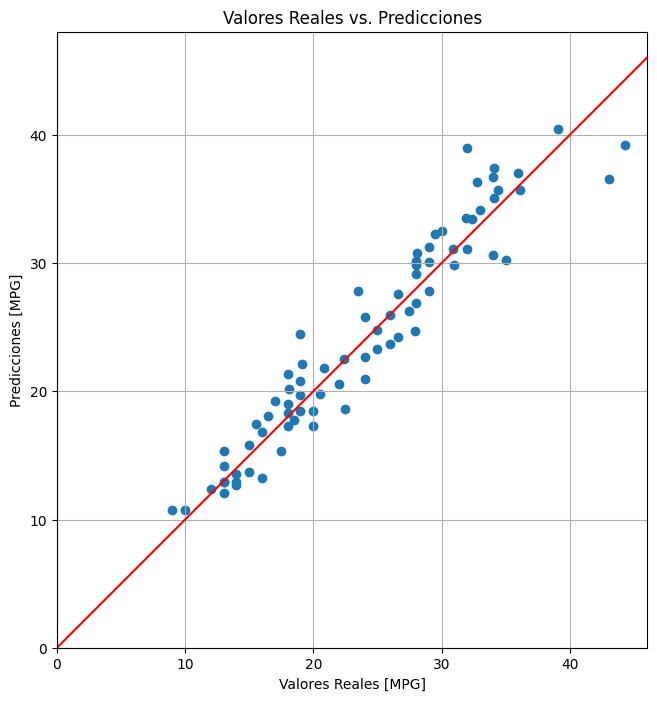

In [30]:
# 6.1 Evaluación del Modelo
# Evaluar el rendimiento del modelo en el conjunto de prueba.
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print(f"\nError Absoluto Medio en el conjunto de prueba: {mae:.2f} MPG")

# 6.2 Visualización de Predicciones
# Realizar predicciones en el conjunto de prueba
test_predictions = model.predict(normed_test_data).flatten()
# Graficar los valores reales vs. las predicciones
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions)
plt.xlabel('Valores Reales [MPG]')
plt.ylabel('Predicciones [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
# Dibuja la línea de predicción perfecta
_ = plt.plot([-100, 100], [-100, 100], color='red')
plt.title('Valores Reales vs. Predicciones')
plt.grid(True)
plt.show()
